# Flow Model for Lattice Field Theory

Author: Haimeng Zhao

Email: haimengzhao@icloud.com

This notebook contains the code and a detailed note for utilizing flow-based models to sample from complicated probability distributions, especially those encountered in many-body systems. 

We first introduce the flow model in a general setting, and then use the flow model to study the lattice $\phi^4$ theory as an example.

The method implemented here is based on several papers ([arXiv:1904.12072](https://inspirehep.net/literature/1731778), [arXiv:2002.02428](https://inspirehep.net/literature/1779199), and [arXiv:2003.06413](https://inspirehep.net/literature/1785309)) and a tutorial [arXiv:2101.08176](https://arxiv.org/abs/2101.08176). 

We first import some useful packages and check whether GPUs are available (if not, CPUs will be used instead).

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Use CPU or GPU
if torch.cuda.is_available():
    torch_device = 'cuda'
    float_dtype = np.float32 # single
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
    torch_device = 'cpu'
    float_dtype = np.float64 # double
    torch.set_default_tensor_type(torch.DoubleTensor)
print(f"TORCH DEVICE: {torch_device}")


TORCH DEVICE: cpu


Here we borrow some useful functions from 2101.08176.

- `grab` is used to move tensors to cpu. 

- `init_live_plot, moving_average, update_plots` is used to make live-updating plots for monitoring training process.


In [3]:
'''
Ref: 2101.08176
'''

def grab(var):
    return var.detach().cpu().numpy()

from IPython.display import display

def init_live_plot(dpi=125, figsize=(8,4), N_era=25, N_epoch=100):
    fig, ax_ess = plt.subplots(1, 1, dpi=dpi, figsize=figsize)
    plt.xlim(0, N_era * N_epoch)
    plt.ylim(0, 1)
    
    ess_line = plt.plot([0], [0], alpha=0.5) # dummy
    plt.grid(False)
    plt.ylabel('ESS')
    
    ax_loss = ax_ess.twinx()
    loss_line = plt.plot([0], [0], alpha=0.5, c='orange') # dummy
    plt.grid(False)
    plt.ylabel('Loss')
    
    plt.xlabel('Epoch')

    display_id = display(fig, display_id=True)

    return dict(
        fig=fig, ax_ess=ax_ess, ax_loss=ax_loss,
        ess_line=ess_line, loss_line=loss_line,
        display_id=display_id
    )

def moving_average(x, window=10):
    if len(x) < window:
        return np.mean(x, keepdims=True)
    else:
        return np.convolve(x, np.ones(window), 'valid') / window

def update_plots(history, fig, ax_ess, ax_loss, ess_line, loss_line, display_id):
    Y = np.array(history['ess'])
    Y = moving_average(Y, window=15)
    ess_line[0].set_ydata(Y)
    ess_line[0].set_xdata(np.arange(len(Y)))
    Y = history['loss']
    Y = moving_average(Y, window=15)
    loss_line[0].set_ydata(np.array(Y))
    loss_line[0].set_xdata(np.arange(len(Y)))
    ax_loss.relim()
    ax_loss.autoscale_view()
    fig.canvas.draw()
    display_id.update(fig) # need to force colab to update plot

## Introduction

The essential idea behind this method is to use a neural network to learn the transformation from a simple distribution (the prior), which can be easily sampled, to the complicated distribution we target at (see the figure below from 1904.12072).

![Fig. 1 of 1904.12072](./assets/normalizing_flow.png)

For example, we can choose the prior to be a simple normal distribution.

In [4]:
class NormalPrior:
    def __init__(self, mean, var):
        self.mean = torch.flatten(mean)
        self.var = torch.flatten(var)
        self.dist = torch.distributions.normal.Normal(self.mean, self.var)
        self.shape = mean.shape

    def log_prob(self, x):
        logp = self.dist.log_prob(x.reshape(x.shape[0], -1))
        return torch.sum(logp, dim=1)

    def sample(self, batch_size):
        x = self.dist.sample((batch_size,))
        return x.reshape(batch_size, *self.shape)

Note that here for the purpose of lattice field theory, we assume the target density $p(x)$ to be $e^{-S}/Z$, where $S$ is the action of the field theory and $Z$ the normalization constant.

When the neural network successfully learned the desired transformation, we can then sample from the prior and apply the neural network to map our samples to the desired distribution.

In [5]:
def apply_flow_to_prior(prior, layers, batch_size):
    # sample from prior
    x = prior.sample(batch_size)
    logq = prior.log_prob(x)

    # flow through the model
    for l in layers:
        x, logJ = l.forward(x)
        logq = logq - logJ
    
    return x, logq

Since the neural network represents a gradual "flow" of distribution from the prior to the target, it is called a flow model. To further stress that each slice of the flow is a distribution itself which satisfies the normalizing condition $\int p(x) dx = 1$, the model is often called a normalizing flow.

However, the trained neural network is only an approximation, thus the samples drawn directly through the flow is biased. To produce unbiased samples and thus measure observables, we still need resample precedures such as Markov chain Monte Carlo (MCMC). (If you only need an approximation, direct sampling through the flow will be enough).

But this time MCMC will require significantly less burn-in time and is more robust to model parameters thanks to the flow. Furthermore, sampling with the flow is also free from the fermion sign problem (though it requires the flow to have a property called "equivariant", which happens to be met by the well-known transformer model from the field of natural language processing). In addition, since flow can be run in parrallel, MCMC will be significantly faster. Thus the resulting MCMC-flow hybrid sampler is much better than a simple MCMC.

To quantify the quality of flow model samples, we can use the effective sample size (ESS) (which serves a similar role as autocorrelation time in MCMC)
$$
ESS = \frac{ \left(\frac{1}{N} \sum_i p(x_i)/q(x_i) \right)^2 }{ \frac{1}{N} \sum_i \left( p(x_i)/q(x_i) \right)^2 } \in [0, 1].
$$
Here a larger ESS indicates better sampling, and $ESS=1$ represents a perfect sampling from the desired distribution.

In [6]:
def ess(logp, logq):
    logw = logp - logq
    log_ess = 2 * torch.logsumexp(logw, dim=0) - torch.logsumexp(2 * logw, dim=0)
    return torch.exp(log_ess) / len(logw)

## Normalizing Flow

Now we dive into the detail of normalizing flow.

Translating the above intuition into rigorous math, we aim to find a transformation $f(z)$ which maps a random variable $z$ with a simple prior density $r(z)$ to the ouput variable $x = f(z)$ with density $q(x)$. By the change-of-variable formula we have

$$
q(x) = r(z)|J|^{-1} = r(z)\left |\det \frac{\partial f_i(z)}{\partial z_j}\right |^{-1},
$$

where $J = \det \frac{\partial f_i(z)}{\partial z_j}$ is the Jacobian. 

That's all it is! A change of variable. Now we only need to train a neural network to find the optimal $f$ which minimizes the distance between the output density $q(x)$ and the target density $p(x)$:
$$
f = \argmin_f d(q, p).
$$

A common choice use to measure the distance between two distributions is the Kullback-Leibler (KL) divergence
$$
D_{KL}(q||p) = \int dx \ q(x)[\log q(x) - \log p(x)],
$$
which can be estimated by
$$
\hat{D}_{KL}(q||p) = \frac{1}{N}\sum_i^N[\log q(x_i) - \log p(x_i)], \quad x_i \sim q.
$$

In [8]:
def kl_divergence(logp, logq):
    return torch.mean(logq - logp)

Here we can see the advantage of flow models compared with traditional method. We only need to sample from the "model distribution" $q(x)$, which can be generated easily from the prior, while traditional methods such as HMC require sampling from $p(x)$.

To make it short, our training procedure consists of
1. Drawing samples from the prior and flow through the model,
2. Estimate the KL divergence,
3. Use optimization methods such as SGD or Adam to minimize the KL divergence.

During training, we monitor the KL divergence (loss function) and ESS to keep track of the training process.

In [9]:
def train(model, action, optimizer, batch_size, metrics):
    layers, prior = model['layers'], model['prior']
    optimizer.zero_grad()

    x, logq = apply_flow_to_prior(prior, layers, batch_size)
    logp = -action(x)
    loss = kl_divergence(logp, logq)

    loss.backward()
    optimizer.step()

    metrics['loss'].append(grab(loss))
    metrics['logp'].append(grab(logp))
    metrics['logq'].append(grab(logq))
    metrics['ess'].append(grab(ess(logp, logq)))

def print_metrics(era, epoch, history, avg_last_N_epochs):
    print(f'== Era {era} | Epoch {epoch} metrics ==')
    for key, val in history.items():
        avgd = np.mean(val[-avg_last_N_epochs:])
        print(f'\t{key} {avgd:g}')

What we are left with now is how to design a flow $f$ that is expressive enough while keeping its Jacobian tractable.

## Design the flow $f$

To design a flow that is both expressive enough and tractable, people have came up with different solutions. Two notable examples are coupling layers and Monge-Ampere flow (see arXiv:1809.10188 where the authors demonstrated this approach in MNIST generation and Ising Model sampling). Here we will focus on coupling layers following arXiv:1904.12072. Nevertheless, Monge-Ampere flow might achieve better performance since it's in some sense the continuous version of coupling layers.

Coupling layers aims at constructing transformation whose Jacobian matrix is triangular, of which the determinant can be easily read off.

In a coupling layer, a subset of the parameters is transformed by a manifestly invertable function such as affine transformation $x\to e^s x+t$. For example
\begin{align*}
x_1' &= e^{-s(x_2)}x_1,\\
x_2' &= x_2.
\end{align*}
Its Jacobian is simply
$$
J = 
\begin{pmatrix}
\frac{\partial x_1'}{\partial x_1} & \frac{\partial x_1'}{\partial x_2}\\
0 & 1
\end{pmatrix},
$$
and its determinant easily follows
$$
\det J = \prod_i e^{[s(x_2)]_i}.
$$

By design powerful enough function $s(x)$ (e.g. use a CNN), and composing lots of coupling layers, we can make the flow more expressive. Composing lots of layers gives
$$
q(x) = r(z)\left |\det \frac{\partial f_i(z)}{\partial z_j}\right |^{-1} = r(z)\prod_l J^{-1}_l,
$$
where $J_l$ is the Jacobian of the $l$ th layer.

To partition variables into $x_1$ and $x_2$, we adopt the checkerboard mask. Those assigned $1$ will be transformed.

In [10]:
def get_mask(shape, parity):
    mask = torch.ones(shape, dtype=torch.uint8)
    mask -= parity
    mask[::2, ::2] = parity
    mask[1::2, 1::2]= parity
    return mask.to(torch_device)

print('example mask:\n', get_mask((8, 8), 1))

example mask:
 tensor([[1, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1, 0, 1]], dtype=torch.uint8)


Now we can build our coupling layer.

Note that the reverse process is just as simple as the forward one.

In [11]:
class CouplingLayer(torch.nn.Module):
    def __init__(self, net, mask_shape, mask_parity):
        super().__init__()
        self.mask = get_mask(mask_shape, mask_parity)
        self.net = net

    def forward(self, x):
        x_2 = self.mask * x      
        x_1 = (1 - self.mask) * x
        func = self.net(x_2.unsqueeze(1))
        s, t = func[:,0], func[:,1]
        fx = (1 - self.mask) * t + x_1 * torch.exp(s) + x_2
        axes = range(1, len(s.size()))
        logJ = torch.sum((1 - self.mask) * s, dim=tuple(axes))
        return fx, logJ

    def reverse(self, fx):
        fx_2 = self.mask * fx
        fx_1 = (1 - self.mask) * fx  
        func = self.net(fx_2.unsqueeze(1))
        s, t = func[:,0], func[:,1]
        x = (fx_1 - (1 - self.mask) * t) * torch.exp(-s) + fx_2
        axes = range(1,len(s.size()))
        logJ = torch.sum((1 - self.mask)*(-s), dim=tuple(axes))
        return x, logJ

We use CNN as the function.

In [12]:
def get_CNN(hidden_sizes, kernel_size, in_channels, out_channels):
    sizes = [in_channels] + hidden_sizes + [out_channels]
    padding_size = (kernel_size // 2)
    layers = []
    for i in range(len(sizes) - 1):
        layers.append(torch.nn.Conv2d(sizes[i], sizes[i+1], kernel_size, padding=padding_size, stride=1, padding_mode='circular'))
        if i != len(sizes) - 2:
            layers.append(torch.nn.PReLU())
        else:
            layers.append(torch.nn.Tanh())
    return torch.nn.Sequential(*layers)

With the tools at hand, we can finally assemble a flow model.

In [13]:
def get_flow(n_layers, lattice_shape, hidden_sizes, kernel_size):
    layers = []
    for i in range(n_layers):
        parity = i % 2
        net = get_CNN(hidden_sizes, kernel_size, in_channels=1, out_channels=2)
        coupling_layer = CouplingLayer(net, lattice_shape, parity)
        layers.append(coupling_layer)
    return torch.nn.Sequential(*layers)

## Example: 2-dim lattice $\phi^4$ theory

### Physics
Now we take 2-dim lattice scalar $\phi^4$ theory as an example to illustrate the flow model. This part follows arXiv:1904.12072.

$\phi^4$ field theory assign a real value $\phi(x)$ to each coordinate $x$ and follows the Boltzmann distribution
$$
p = \frac{1}{Z}e^{-S(\phi)},
$$
where $Z$ is the normalizing constant and $S$ is the action.

In continuous 2-dim theory, the $\phi^4$ action reads
$$
S[\phi] = \int d^2x (\partial \phi)^2 + m^2\phi^2 + \lambda \phi^4.
$$
Discretizing it on a lattice gives
$$
S(\phi) = \sum_n\left [ \phi(n) \sum_{m\in\text{neighbor}(n)} [\phi(n) - \phi(m)] + m^2\phi^2(n) + \lambda \phi^4(n) \right ].
$$
As for finite lattice, we set periodic boundary condition.

In [14]:
class ScalarPhi4Action():
    def __init__(self, m2, lam):
        self.m2 = m2
        self.lam = lam
    
    def __call__(self, state):
        # potential
        action_density = self.m2 * state ** 2 + self.lam * state ** 4
        # kinetic
        dims = range(1, len(state.shape))
        for direction in dims:
            action_density += 2 * state ** 2
            action_density -= state * torch.roll(state, -1, direction) 
            action_density -= state * torch.roll(state, 1, direction)
        
        return torch.sum(action_density, dim=tuple(dims))

### Parameters

Recall that in Landau's theory of phase transition, when $m^2 < 0$ and $\lambda$ lower than a critical value $\lambda_c$, there will be a spontaneous symmetry breaking. For simplicity, we focus on non-breaking phase, but stay close to the critical point so that we can see relatively large correlation length. We test our model on a $8\times 8$ lattice.

In [15]:
L = 8; lattice_shape = (L,L)
m2 = -4; lam = 8
phi4_action = ScalarPhi4Action(m2, lam)

### Prior

We choose the prior distribution to be i.i.d. simple gaussians at each lattice. Then in some sense, the flow's task is to gradually introduce the correlations.

We can visualize some samples here.

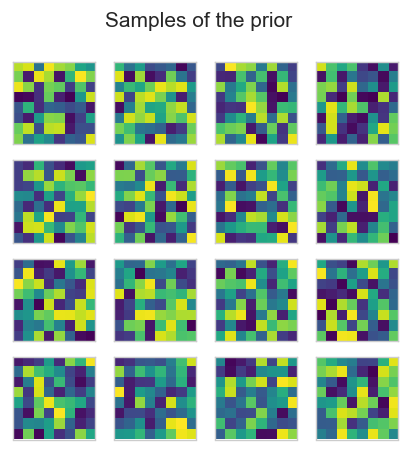

In [16]:
prior = NormalPrior(torch.zeros(lattice_shape), torch.ones(lattice_shape))

z_torch = prior.sample(1024)
z = grab(z_torch)
fig, ax = plt.subplots(4, 4, dpi=125, figsize=(4, 4))
for i in range(4):
    for j in range(4):
        ind = i * 4 + j
        ax[i,j].imshow(np.tanh(z[ind]), vmin=-1, vmax=1, cmap='viridis')
        ax[i,j].axes.xaxis.set_visible(False) 
        ax[i,j].axes.yaxis.set_visible(False)
fig.suptitle("Samples of the prior")
plt.show()

Indeed we find no trace of correlation (e.g. patches).

We can further examine correlations between different sites by drawing histograms.

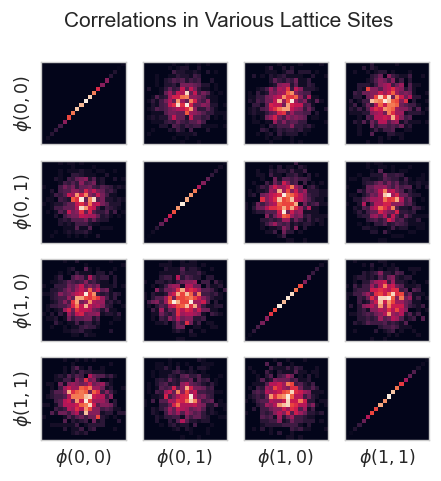

In [17]:
fig, ax = plt.subplots(4, 4, dpi=125, figsize=(4,4))

for x1 in range(2):
    for y1 in range(2):
        i1 = x1 * 2 + y1
        for x2 in range(2):
            for y2 in range(2):
                i2 = x2 * 2 + y2

                ax[i1,i2].hist2d(z[:,x1,y1], z[:,x2,y2], range=[[-3,3],[-3,3]], bins=20)
                ax[i1,i2].set_xticks([])
                ax[i1,i2].set_yticks([])

                if i1 == 3:
                    ax[i1,i2].set_xlabel(rf'$\phi({x2},{y2})$')
                if i2 == 0:
                    ax[i1,i2].set_ylabel(rf'$\phi({x1},{y1})$')
                    
fig.suptitle("Correlations in Various Lattice Sites")
plt.show()

As still another metric, we can calculate the "effective action" of our model $-\log r(z)$ and compare it with the desired action $S$. If our model fits well (of course not since we haven't start training yet), they should be approximately the same up to a shift (normalizing constant) and lie close to a $y=x + b$ line.

slope 1 linear regression S = -logr + 1471.1966


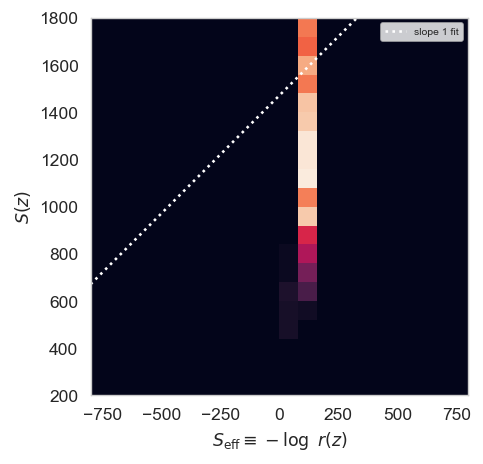

In [18]:
S_eff = - grab(prior.log_prob(z_torch))
S = grab(phi4_action(z_torch))

fit_b = np.mean(S) - np.mean(S_eff)
print(f'slope 1 linear regression S = -logr + {fit_b:.4f}')

fig, ax = plt.subplots(1, 1, dpi=125, figsize=(4,4))
ax.hist2d(S_eff, S, bins=20, range=[[-800, 800], [200,1800]])
xs = np.linspace(-800, 800, num=4, endpoint=True)
ax.plot(xs, xs + fit_b, ':', color='w', label='slope 1 fit')
ax.set_xlabel(r'$S_{\mathrm{eff}} \equiv -\log~r(z)$')
ax.set_ylabel(r'$S(z)$')
ax.set_aspect('equal')

plt.legend(prop={'size': 6})
plt.show()

That's expected since we haven't started training the model yet!

### Training

Now we build a flow and perform the training.

25 eras of training takes about 15 min on the CPU of a laptop.

In [19]:
n_layers = 16; hidden_sizes = [8, 8]; kernel_size = 3
flow = get_flow(n_layers, lattice_shape, hidden_sizes, kernel_size)
model = {'layers': flow, 'prior': prior}

learning_rate = 1e-3
optimizer = torch.optim.Adam(model['layers'].parameters(), lr=learning_rate)

We have prepared a pretrained model.

You can load it and skip the training, or train your own one.

In [26]:
state_dict = torch.load('./flow.ckpt', map_location='cpu')
model['layers'].load_state_dict(state_dict)
model['layers'].to(torch_device)
use_pretrain = True

In [29]:
N_era = 25
N_epoch = 100
batch_size = 64
print_freq = N_epoch
plot_freq = 1

history = {
    'loss' : [],
    'logp' : [],
    'logq' : [],
    'ess' : []
}

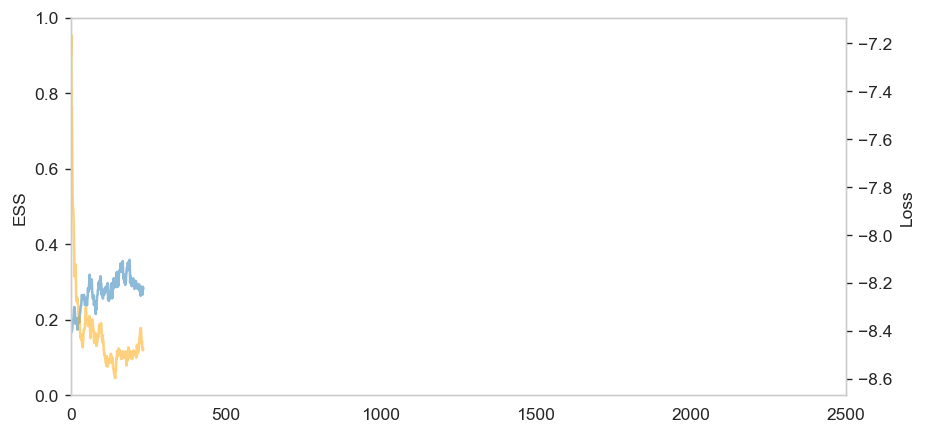

== Era 0 | Epoch 0 metrics ==
	loss -8.61876
	logp -10.7109
	logq -19.3296
	ess 0.150726
== Era 1 | Epoch 0 metrics ==
	loss -8.18426
	logp -11.3066
	logq -19.4909
	ess 0.236346
== Era 2 | Epoch 0 metrics ==
	loss -8.50389
	logp -11.068
	logq -19.5719
	ess 0.302644


KeyboardInterrupt: 

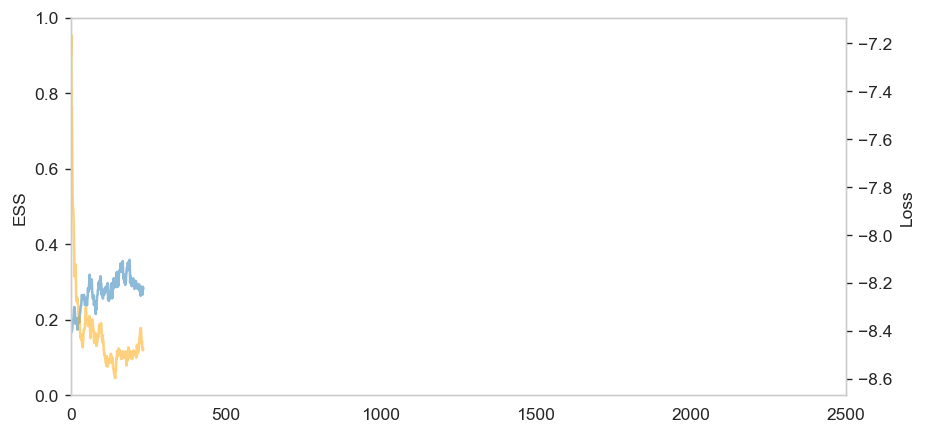

In [30]:
# close all existing figures
[plt.close(plt.figure(fignum)) for fignum in plt.get_fignums()]
# initialize figure
live_plot = init_live_plot()

for era in range(N_era):
    for epoch in range(N_epoch):
        train(model, phi4_action, optimizer, batch_size, history)

        if epoch % print_freq == 0:
            print_metrics(era, epoch, history, avg_last_N_epochs=print_freq)

        if epoch % plot_freq == 0:
            update_plots(history, **live_plot)

We can save our trained model for later use.

In [39]:
torch.save(model['layers'].state_dict(), './flow.ckpt')

### Evaluate

Now we can evaluate our model by drawing samples from the prior and let it flow throught the model.

As we did before, we first examine some samples.

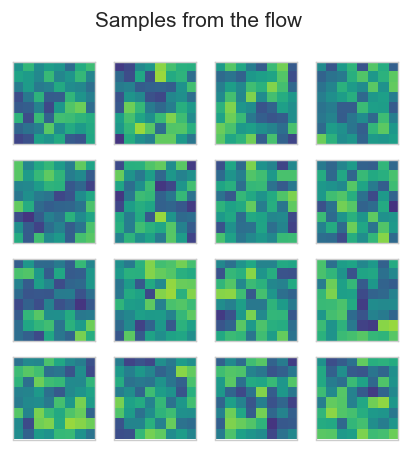

In [22]:
x_torch, logq_torch = apply_flow_to_prior(prior, flow, batch_size=1024)
x = grab(x_torch)

fig, ax = plt.subplots(4, 4, dpi=125, figsize=(4,4))
for i in range(4):
    for j in range(4):
        ind = i * 4 + j
        ax[i,j].imshow(np.tanh(x[ind]), vmin=-1, vmax=1, cmap='viridis')
        ax[i,j].axes.xaxis.set_visible(False)
        ax[i,j].axes.yaxis.set_visible(False)
fig.suptitle("Samples from the flow")
plt.show()

Samples from the flow exhibits clear correlation. It's much smoother than the uncorrelated samples.

Now we examine the learned effective action just as before.

slope 1 linear regression S = S_eff + -8.4461


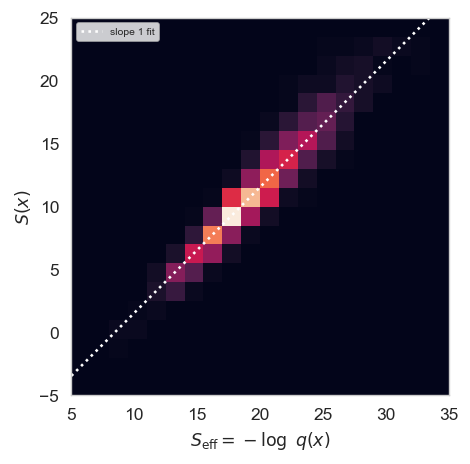

In [23]:
S_eff = -grab(logq_torch)
S = grab(phi4_action(x_torch))
fit_b = np.mean(S) - np.mean(S_eff)
print(f'slope 1 linear regression S = S_eff + {fit_b:.4f}')
fig, ax = plt.subplots(1, 1, dpi=125, figsize=(4,4))
ax.hist2d(S_eff, S, bins=20, range=[[5, 35], [-5, 25]])
ax.set_xlabel(r'$S_{\mathrm{eff}} = -\log~q(x)$')
ax.set_ylabel(r'$S(x)$')
ax.set_aspect('equal')
xs = np.linspace(5, 35, num=4, endpoint=True)
ax.plot(xs, xs + fit_b, ':', color='w', label='slope 1 fit')
plt.legend(prop={'size': 6})
plt.show()

It can be readily seen that the learned action approximate the desired one well.

Use the record we keep during training (if not using pretrained model), we can examine how the flow gradually learned the action.

In [27]:
if not use_pretrain:
    fig, axes = plt.subplots(1, 10, dpi=125, sharey=True, figsize=(10, 1))
    logq_hist = np.array(history['logq']).reshape(N_era, -1)[::N_era//10]
    logp_hist = np.array(history['logp']).reshape(N_era, -1)[::N_era//10]
    for i, (ax, logq, logp) in enumerate(zip(axes, logq_hist, logp_hist)):
        ax.hist2d(-logq, -logp, bins=20, range=[[5, 35], [-5, 25]])
        ax.set_title(f'Era {i * (N_era//10)}')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('equal')
        if i == 0:
            ax.set_ylabel(r'$S(x)$')
            ax.set_xlabel(r'$S_{\mathrm{eff}}$')
            ax.set_title(f'Era {i * (N_era//10)}')
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_aspect('equal')
    plt.show()

### Spontaneous Symmetry Breaking

Now we construct a $\phi^4$ theory with spontaneous symmetry breaking.

In [ ]:
L = 8; lattice_shape = (L,L)
m2 = -4; lam = 1
phi4_action = ScalarPhi4Action(m2, lam)

n_layers = 16; hidden_sizes = [8, 8]; kernel_size = 3
flow = get_flow(n_layers, lattice_shape, hidden_sizes, kernel_size)
model = {'layers': flow, 'prior': prior}

learning_rate = 1e-3
optimizer = torch.optim.Adam(model['layers'].parameters(), lr=learning_rate)

N_era = 25
N_epoch = 100
batch_size = 64
print_freq = N_epoch
plot_freq = 1

history = {
    'loss' : [],
    'logp' : [],
    'logq' : [],
    'ess' : []
}

# close all existing figures
[plt.close(plt.figure(fignum)) for fignum in plt.get_fignums()]
# initialize figure
live_plot = init_live_plot()

for era in range(N_era):
    for epoch in range(N_epoch):
        train(model, phi4_action, optimizer, batch_size, history)

        if epoch % print_freq == 0:
            print_metrics(era, epoch, history, avg_last_N_epochs=print_freq)

        if epoch % plot_freq == 0:
            update_plots(history, **live_plot)